In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

from scikits.sparse.cholmod import cholesky


#analysis_name = 'simulated_data_small'
analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])

model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

model.glmm_par.set_free(vb_data['glmm_par_free'])
kl_hess = vb_sparse.unpack_csr_matrix(vb_data['kl_hess_packed'])

In [5]:
sp_kl_hess = \
    model.group_model.get_sparse_kl_vec_hessian(print_every_n=500) + \
    model.global_model.get_sparse_kl_vec_hessian()
#kl_hess = np.asarray(sp_kl_hess.todense())

Group 0 of 4999.
Group 500 of 4999.
Group 1000 of 4999.
Group 1500 of 4999.
Group 2000 of 4999.
Group 2500 of 4999.
Group 3000 of 4999.
Group 3500 of 4999.
Group 4000 of 4999.
Group 4500 of 4999.


In [8]:
#kl_hess_inv = np.linalg.inv(kl_hess)
#sp_kl_hess_inv = sp.sparse.linalg.inv(sp_kl_hess)

In [9]:
model.global_model.set_global_parameters()
global_indices = model.global_model.global_indices.get_vector()

def get_re_indices(g):
    vec, ind = model.group_model.set_re_parameters([g])
    return ind

get_re_indices([2])

all_re_indices = np.setdiff1d(np.arange(0, model.glmm_par.vector_size()), global_indices)

global_ix = np.ix_(global_indices, global_indices)
re_ix = np.ix_(all_re_indices, all_re_indices)
cross_ix = np.ix_(global_indices, all_re_indices)

# plt.matshow(kl_hess[np.ix_(all_re_indices, all_re_indices)]); plt.colorbar()
# plt.matshow(kl_hess[np.ix_(global_indices, all_re_indices)]); plt.colorbar()
# plt.matshow(kl_hess[np.ix_(global_indices, global_indices)]); plt.colorbar()

In [14]:
sp_kl_hess[global_ix]
sp_kl_hess_inv_term = sp.sparse.linalg.spsolve(sp_kl_hess[re_ix], sp_kl_hess[cross_ix].T)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [29]:
global_schur_inv = sp_kl_hess[global_ix] - sp_kl_hess[cross_ix] * sp_kl_hess_inv_term
global_schur = sp.sparse.linalg.inv(global_schur_inv)
global_schur = np.asarray(global_schur.todense())
#print(np.linalg.norm(global_schur - kl_hess_inv[global_ix]))

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [21]:
def get_schur_term(g):
    g_re_ind = get_re_indices([g])
    g_cross_ix = np.ix_(global_indices, g_re_ind)
    g_re_ix = np.ix_(g_re_ind, g_re_ind)
    sparse_result = sp_kl_hess[g_cross_ix] * \
                    sp.sparse.linalg.spsolve(sp_kl_hess[g_re_ix], sp_kl_hess[g_cross_ix].T)
    return np.asarray(sparse_result.todense())
    
schur_terms = []
for g in range(NG):
    if g % 500 == 0:
        print('{} of {}'.format(g + 1, NG))
    schur_terms.append(get_schur_term(g))
print('Done')


1 of 5000


/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


501 of 5000
1001 of 5000
1501 of 5000
2001 of 5000
2501 of 5000
3001 of 5000
3501 of 5000
4001 of 5000
4501 of 5000
Done


0.00103098899126


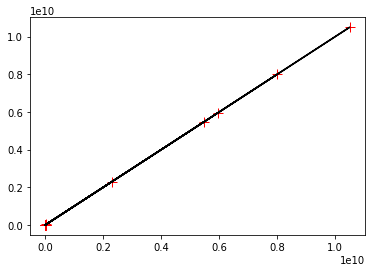

In [38]:
schur_terms = np.array(schur_terms)
kl_hess_global = np.asarray(sp_kl_hess[global_ix].todense())
global_schur_inv_terms = kl_hess_global - np.sum(schur_terms, axis=0)
global_schur_terms = np.linalg.inv(global_schur_inv_terms)
print(np.max(np.abs((global_schur_terms - global_schur))))
plt.plot(global_schur_terms.flatten(), global_schur.flatten(), 'r+', markersize=10)
plt.plot(global_schur_terms.flatten(), global_schur_terms.flatten(), 'k')

In [41]:
diff_list = []
for num_g in range(1, NG + 1):
    if num_g % 500 == 0:
        print('{} of {}'.format(num_g, NG))
    global_schur_inv = kl_hess_global - (NG / num_g) * np.sum(schur_terms[np.arange(0, num_g),:,:], axis=0)
    global_schur = np.linalg.inv(global_schur_inv)
    diff = global_schur - global_schur_terms
    diff_list.append(diff)

500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
5000 of 5000


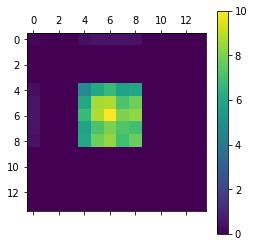

In [42]:
plt.matshow(np.std(schur_terms, axis=0)); plt.colorbar()

In [ ]:
for ind in range(len(global_indices)):
    plt.figure()
    plt.plot([np.abs(diff[ind, ind]) for diff in diff_list], '.')